In [1]:
base_url = "D:/downloads"
image_path = "/jpeg/train"
image_path1 = "/HAM10000_images_part_1"
import os
import pandas as pd
print(len(os.listdir(base_url + image_path)))
print(len(os.listdir(base_url + image_path1)))

43141
10014


In [2]:
import csv
import numpy as np
with open(base_url + '/train.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[0,-1]])

with open(base_url + '/HAM10000_metadata.csv') as file_name:
    file_read = csv.reader(file_name)
    array = list(file_read)
    np_arr = np.array(array)
print(np_arr[1:,[1,2]])

[['ISIC_2637011' '0']
 ['ISIC_0015719' '0']
 ['ISIC_0052212' '0']
 ...
 ['ISIC_9999515' '0']
 ['ISIC_9999666' '0']
 ['ISIC_9999806' '0']]
[['ISIC_0027419' 'bkl']
 ['ISIC_0025030' 'bkl']
 ['ISIC_0026769' 'bkl']
 ...
 ['ISIC_0033536' 'akiec']
 ['ISIC_0032854' 'akiec']
 ['ISIC_0032258' 'mel']]


In [3]:
#read in train csv
train = pd.read_csv(base_url + '/train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

data = train

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Number of positive images in subset of train set: {}'.format(n_pos))
print('Percentage of positive images in subset train set: {:.1%}'.format(n_pos/len(data)))
print('Number of negative images in subset train set: {}'.format(len(data) - n_pos))
print('Percentage of negative images in subset train set: {:.1%}'.format(1 - n_pos/len(data)))


image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0
number of images in full train set: 33058
Number of positive images in subset of train set: 584
Percentage of positive images in subset train set: 1.8%
Number of negative images in subset train set: 32474
Percentage of negative images in subset train set: 98.2%


In [4]:
#zmenime typ hodnoty s druheho datasetu na typ s prveho datasetu aby sme mohli potom dva datasety spojit
train1 = pd.read_csv(base_url + '/HAM10000_metadata.csv')
data1 = train1

malign_data1 = data1[data1['dx']=='mel'].to_numpy()[1:,[1,2]]
benign_data1 = data1[data1['dx']=='nv'].to_numpy()[1:,[1,2]]
#print(malign_data)
#print(benign_data)
#print(malign_data[1:,1])
#print(malign_data)
#print(malign_data[0][1])
malign_data1[0][1] = 1
benign_data1[0][1] = 0
for cislo in range(len(malign_data1[1:,1])):
    if malign_data1[1:,1][cislo-1] == 'mel':
        malign_data1[1:,1][cislo-1] = 1

for cislo in range(len(benign_data1[1:,1])):
    if benign_data1[1:,1][cislo] == 'nv':
        benign_data1[1:,1][cislo] = 0

print(malign_data1, '\n')
print(benign_data1)

[['ISIC_0030623' 1]
 ['ISIC_0027190' 1]
 ['ISIC_0031023' 1]
 ...
 ['ISIC_0032936' 1]
 ['ISIC_0033232' 1]
 ['ISIC_0032258' 1]] 

[['ISIC_0024693' 0]
 ['ISIC_0032212' 0]
 ['ISIC_0025775' 0]
 ...
 ['ISIC_0032221' 0]
 ['ISIC_0030693' 0]
 ['ISIC_0031649' 0]]


In [5]:
train = pd.read_csv(base_url + '/train.csv')
data = train
malign_data = data[data['target']==1].to_numpy()[1:,[0,-1]]
benign_data = data[data['target']==0].to_numpy()
idx_x = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
benign_data = np.array(benign_data[idx_x])

benign_data = benign_data[:len(malign_data)+1]
benign_data = benign_data[1:,[0,-1]]
print(benign_data.size)
print(malign_data.size)

benign_data = np.concatenate([benign_data, benign_data1])
malign_data = np.concatenate([malign_data, malign_data1])

print(benign_data)
print(malign_data)

benign_data = benign_data[:1695]
#malign_data = malign_data[:1500]

print(len(benign_data))
print(len(malign_data))



#benign_data = benign_data.reshape(583 , 2) + benign_data1.reshape(6704, 2)
#malign_data = malign_data + malign_data1

#print(benign_data)
#print(malign_data)
#print(len(benign_data))
#print(len(malign_data))


1166
1166
[['ISIC_9396628' 0]
 ['ISIC_9264993' 0]
 ['ISIC_8975142' 0]
 ...
 ['ISIC_0032221' 0]
 ['ISIC_0030693' 0]
 ['ISIC_0031649' 0]]
[['ISIC_0188432' 1]
 ['ISIC_0207268' 1]
 ['ISIC_0232101' 1]
 ...
 ['ISIC_0032936' 1]
 ['ISIC_0033232' 1]
 ['ISIC_0032258' 1]]
1695
1695


In [6]:
shuffle_benign = np.random.choice(len(benign_data),int(len(benign_data)),replace=False)
shuffle_malign = np.random.choice(len(malign_data),int(len(malign_data)),replace=False)
idx_train_benign = shuffle_benign[:int(len(shuffle_benign)*0.70)]
idx_test_benign = shuffle_benign[int(len(shuffle_benign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_benign = shuffle_benign[int(len(shuffle_benign)*0.85):int(len(shuffle_benign)*1)]
idx_train_malign = shuffle_malign[:int(len(shuffle_malign)*0.70)]
idx_test_malign = shuffle_malign[int(len(shuffle_malign)*0.70):int(len(shuffle_benign)*0.85)]
idx_valid_malign = shuffle_malign[int(len(shuffle_malign)*0.85):int(len(shuffle_benign)*1)]

train_data_benign = benign_data[idx_train_benign]
test_data_benign = benign_data[idx_test_benign]
valid_data_benign = benign_data[idx_valid_benign]

train_data_malign = malign_data[idx_train_malign]
test_data_malign = malign_data[idx_test_malign]
valid_data_malign = malign_data[idx_valid_malign]
print(len(train_data_benign))
print(len(train_data_malign))
print(len(test_data_benign))
print(len(test_data_malign))

1186
1186
254
254


In [7]:
train_data = np.concatenate((train_data_benign, train_data_malign), axis=0)
test_data = np.concatenate((test_data_benign, test_data_malign), axis=0)
valid_data = np.concatenate((valid_data_benign, valid_data_malign), axis=0)

shuffle_train = np.random.choice(len(train_data),int(len(train_data)),replace=False)
shuffle_test = np.random.choice(len(test_data),int(len(test_data)),replace=False)
shuffle_valid = np.random.choice(len(valid_data),int(len(valid_data)),replace=False)

train_data = train_data[shuffle_train]
test_data = train_data[shuffle_test]
valid_data = train_data[shuffle_valid]
print(train_data)
print(test_data)
print(valid_data)

[['ISIC_0033120' 1]
 ['ISIC_0952472' 1]
 ['ISIC_0027000' 0]
 ...
 ['ISIC_0779920' 1]
 ['ISIC_0026914' 0]
 ['ISIC_2568374' 0]]
[['ISIC_3319229' 1]
 ['ISIC_0028291' 1]
 ['ISIC_0028017' 1]
 ...
 ['ISIC_5828564' 0]
 ['ISIC_2027582' 1]
 ['ISIC_0032134' 1]]
[['ISIC_0032511' 1]
 ['ISIC_0030657' 0]
 ['ISIC_0025213' 0]
 ...
 ['ISIC_9616071' 0]
 ['ISIC_6912979' 0]
 ['ISIC_0026510' 0]]


In [8]:
import cv2
import matplotlib.pyplot as plt

In [10]:
shapes = []
for img in train_data:
    shapes.append(np.shape(cv2.imread(base_url + image_path+ '/' + img[0] + '.jpg')))
#print(shapes)

KeyboardInterrupt: 

array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>],
       [<AxesSubplot: title={'center': '2'}>, <AxesSubplot: >]],
      dtype=object)

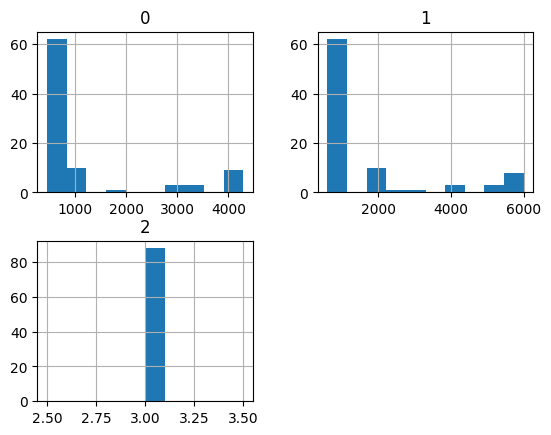

In [11]:
df = pd.DataFrame(data = shapes)
df.hist()

In [12]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print(tf.device('/device:GPU:0'))

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8755858585642884056
xla_global_id: -1
]


In [13]:
import math

In [14]:
train_data[:,1]

array([1, 1, 0, ..., 1, 0, 0], dtype=object)

In [15]:
class Generator(tf.keras.utils.Sequence ):

    def __init__(self, paths, labels, batch_size):
        self.paths, self.labels, self.batch_size = paths, labels, batch_size


    def __len__(self):
        return math.ceil(len(self.paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        

        batch_x = [self.hair_remove(cv2.resize(cv2.imread(base_url + image_path+ '/' + x + '.jpg'), (256 , 256 )).reshape((256,256,3))) for x in batch_x]
        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=2)


    
        return np.array(batch_x), np.array(batch_y)
    def hair_remove(self, image):
    #convert image to greyscale
        grayScale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
        #kernel for morphologyEx
        kernel = cv2.getStructuringElement(1,(17,17))
    
    #apply MORPH_Blackhat to grayscale image
        blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
    #apply thresholding to blackhat
        _, threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    #inpaint with original image and threshold image
        final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)
    
        return final_image




train_gen = Generator(train_data[:,0], train_data[:,1], 4)
test_gen = Generator(test_data[:,0], test_data[:,1], 4)
valid_gen = Generator(valid_data[:,0], valid_data[:,1], 4)
print('done')
print(train_data[:,0])

done
['ISIC_0033120' 'ISIC_0952472' 'ISIC_0027000' ... 'ISIC_0779920'
 'ISIC_0026914' 'ISIC_2568374']


In [16]:
from tensorflow.keras import layers, models

In [17]:
resnet_model = models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(254, activation='relu'))
resnet_model.add(layers.Dense(128, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))


In [18]:
resnet_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

# tf.keras.utils.plot_model(resnet_model)
print('done')

done


In [19]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="first/future.hdf5",
        #     save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

In [21]:
history = resnet_model.fit(train_gen, validation_data=test_gen, epochs=7, callbacks=[model_checkpoint_callback])
print('done')

Epoch 1/7
593/593 [==============================] - 905s 2s/step - loss: 0.3404 - accuracy: 0.8634 - val_loss: 0.2226 - val_accuracy: 0.9055
Epoch 2/7
593/593 [==============================] - 958s 2s/step - loss: 0.2376 - accuracy: 0.8997 - val_loss: 0.1878 - val_accuracy: 0.9134
Epoch 3/7
593/593 [==============================] - 898s 2s/step - loss: 0.2133 - accuracy: 0.9064 - val_loss: 0.1789 - val_accuracy: 0.9252
Epoch 4/7
593/593 [==============================] - 876s 1s/step - loss: 0.1865 - accuracy: 0.9203 - val_loss: 0.1383 - val_accuracy: 0.9409
Epoch 5/7
593/593 [==============================] - 883s 1s/step - loss: 0.1637 - accuracy: 0.9254 - val_loss: 0.1701 - val_accuracy: 0.9193
Epoch 6/7
593/593 [==============================] - 918s 2s/step - loss: 0.1540 - accuracy: 0.9334 - val_loss: 0.1239 - val_accuracy: 0.9429
Epoch 7/7
593/593 [==============================] - 750s 1s/step - loss: 0.1394 - accuracy: 0.9393 - val_loss: 0.1019 - val_accuracy: 0.9626
done


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


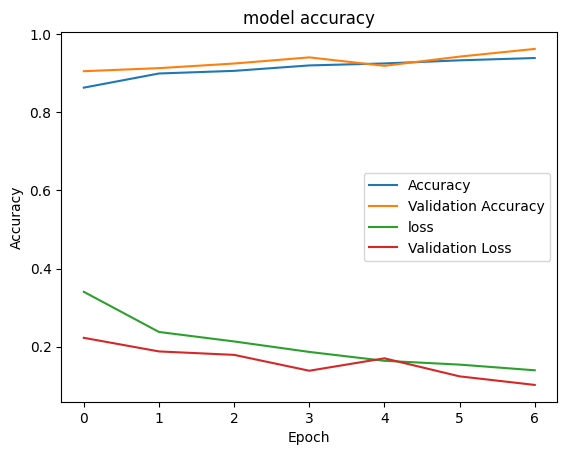

In [22]:
print(history.history.keys())
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [23]:
resnet_model.summary()
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0027315.jpg"
#url = "D:/downloads/HAM10000_images_part_1/ISIC_0024698.jpg"
url = "D:/downloads/HAM10000_images_part_1/ISIC_0029081.jpg"
#img = cv2.imread(url)
img = cv2.resize(cv2.imread(url), (256 , 256 )).reshape((256,256,3))
#print(img)
l = np.array([img])
#l = np.expand_dims(img, axis=0)
print(l)
#img1 = cv2.imread(l)
result = resnet_model.predict(l)
print(result)
print(np.argmax(result))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 254)               520446    
                                                                 
 dense_1 (Dense)             (None, 128)               32640     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,141,056
Trainable params: 553,344
Non-trainable params: 23,587,712
_________________________________________________________________
[[[[15  8 13]
   [17  9 19]
   [22 14 

In [24]:
import cv2